Dataset loaded with 5401 samples
                    id                                           sequence  \
0  AACY020454584.1_604  ACUGGUUGCGGCCAGUAUAAAUAGUCUUUAAGCCGCAAGCGUGUCC...   
1  AACY021048934.1_360  GCUCGGUGCGGCGAGCCUAAAUAGUGCCUUAGGCCGCACGCGUUAU...   
2  AACY021109846.1_859  GGGGGACGAAGUCGAACUGAACACCUCCAUCGUGGUGUCCCCCGGG...   
3  AACY021449234.1_672  AUCUCACAACGUUAAUCGCCUCCUCGUGGCGUGAGAUGGAAACAGC...   
4  AACY021702793.1_630  ACAUUUUGUGGUUUUAAGGGUUAAUCCUUAAGGUUGAUAAACCUUG...   

                                 secondary_structure  
0  ((((........)))).........((..............(((((...  
1  ((((........))))........((((..............((((...  
2  (((((((...............(((........))))))))))......  
3  (((((((..........(((.......)))))))))).....((((...  
4  ...........................((((((........)))))...  

Training BiLSTM (baseline)

Training BiLSTM_1layer

Training BiLSTM_2layers

Training BiLSTM_no_dropout

Training BiLSTM_small_hidden

ABALATION STUDY RESULTS
Model Variant 

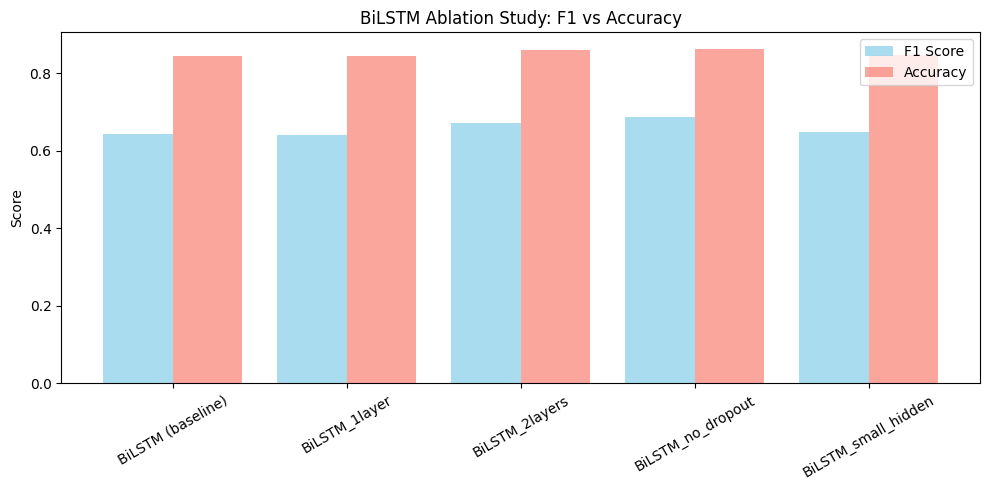

In [3]:
# -----------------------------
# BiLSTM ABLATION STUDY
# -----------------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# -----------------------------
# Dataset loading
# -----------------------------
SEQ_COL = "sequence"
STR_COL = "secondary_structure"

# Load RNA dataset
df = pd.read_parquet("hf://datasets/multimolecule/bprna-new/test.parquet")
print(f"Dataset loaded with {len(df)} samples")
print(df.head())

# Convert dot-bracket notation to paired indices
def dotbracket_to_pairs(dotbracket: str):
    stack = []
    pairs = [-1] * len(dotbracket)
    for i, c in enumerate(dotbracket):
        if c == "(":
            stack.append(i)
        elif c == ")":
            if stack:
                j = stack.pop()
                pairs[i] = j
                pairs[j] = i
    return pairs

df["pairs"] = df[STR_COL].apply(dotbracket_to_pairs)

# -----------------------------
# Vocabulary
# -----------------------------
NUC_TO_ID = {"A": 0, "C": 1, "G": 2, "U": 3}
VOCAB_SIZE = len(NUC_TO_ID)

# -----------------------------
# Dataset class
# -----------------------------
class RNADataset(Dataset):
    def __init__(self, sequences, structures, max_len=200):
        self.sequences = sequences
        self.structures = structures
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def encode_seq(self, seq):
        ids = [NUC_TO_ID.get(c, 0) for c in seq]
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
        else:
            ids += [0] * (self.max_len - len(ids))
        return torch.tensor(ids)

    def encode_labels(self, pairs):
        labels = [1 if p != -1 else 0 for p in pairs]
        if len(labels) > self.max_len:
            labels = labels[:self.max_len]
        else:
            labels += [0] * (self.max_len - len(labels))
        return torch.tensor(labels)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        pairs = self.structures[idx]
        return self.encode_seq(seq), self.encode_labels(pairs)

# -----------------------------
# BiLSTM model base
# -----------------------------
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1, dropout_rate=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True,
                            bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers>1 else 0)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc = nn.Linear(hidden_dim*2, 2)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        return self.fc(out)

# -----------------------------
# Ablation variants
# -----------------------------
class BiLSTM_1layer(BiLSTM):
    def __init__(self, vocab_size):
        super().__init__(vocab_size, embed_dim=64, hidden_dim=128, num_layers=1, dropout_rate=0.2)

class BiLSTM_2layers(BiLSTM):
    def __init__(self, vocab_size):
        super().__init__(vocab_size, embed_dim=64, hidden_dim=128, num_layers=2, dropout_rate=0.2)

class BiLSTM_no_dropout(BiLSTM):
    def __init__(self, vocab_size):
        super().__init__(vocab_size, embed_dim=64, hidden_dim=128, num_layers=2, dropout_rate=0.0)

class BiLSTM_small_hidden(BiLSTM):
    def __init__(self, vocab_size):
        super().__init__(vocab_size, embed_dim=64, hidden_dim=64, num_layers=2, dropout_rate=0.2)

ablation_models = {
    "BiLSTM (baseline)": BiLSTM,
    "BiLSTM_1layer": BiLSTM_1layer,
    "BiLSTM_2layers": BiLSTM_2layers,
    "BiLSTM_no_dropout": BiLSTM_no_dropout,
    "BiLSTM_small_hidden": BiLSTM_small_hidden
}

# -----------------------------
# Training and evaluation functions
# -----------------------------
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_f1_scores = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out.view(-1,2), y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss/len(train_loader))
        
        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                preds = out.argmax(-1).cpu().numpy().ravel()
                labels = y.cpu().numpy().ravel()
                all_preds.extend(preds)
                all_labels.extend(labels)
        if all_preds:
            _, _, f, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
            val_f1_scores.append(f)
        else:
            val_f1_scores.append(0.0)
    return model, train_losses, val_f1_scores

def evaluate(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            preds = out.argmax(-1).cpu().numpy().ravel()
            labels = y.cpu().numpy().ravel()
            all_preds.extend(preds)
            all_labels.extend(labels)
    if all_preds:
        p, r, f, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        return p, r, f, acc
    else:
        return 0.0, 0.0, 0.0, 0.0

# -----------------------------
# Prepare DataLoaders
# -----------------------------
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_ds = RNADataset(train_df[SEQ_COL].tolist(), train_df["pairs"].tolist())
val_ds   = RNADataset(val_df[SEQ_COL].tolist(), val_df["pairs"].tolist())
test_ds  = RNADataset(test_df[SEQ_COL].tolist(), test_df["pairs"].tolist())

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

# -----------------------------
# Run Ablation Study
# -----------------------------
ablation_results = {}
for name, cls in ablation_models.items():
    print(f"\nTraining {name}")
    model = cls(vocab_size=VOCAB_SIZE)
    trained_model, train_losses, val_f1s = train_model(model, train_loader, val_loader, epochs=20)
    p, r, f, acc = evaluate(trained_model, test_loader)
    ablation_results[name] = {'precision': p, 'recall': r, 'f1': f, 'accuracy': acc}

# -----------------------------
# Display Results
# -----------------------------
print("\nABALATION STUDY RESULTS")
print(f"{'Model Variant':<25} {'F1 Score':<10} {'Accuracy':<10}")
print("-"*50)
for name, metrics in ablation_results.items():
    print(f"{name:<25} {metrics['f1']:<10.3f} {metrics['accuracy']:<10.3f}")

# -----------------------------
# Bar Plot
# -----------------------------
models = list(ablation_results.keys())
f1_scores = [ablation_results[m]['f1'] for m in models]
accuracies = [ablation_results[m]['accuracy'] for m in models]

plt.figure(figsize=(10,5))
x = range(len(models))
plt.bar(x, f1_scores, width=0.4, label='F1 Score', alpha=0.7, color='skyblue')
plt.bar([i + 0.4 for i in x], accuracies, width=0.4, label='Accuracy', alpha=0.7, color='salmon')
plt.xticks([i + 0.2 for i in x], models, rotation=30)
plt.ylabel("Score")
plt.title("BiLSTM Ablation Study: F1 vs Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
